# 1. Fitting a local equilibrium model to foam scan data

This notebook explains how mathematical programming can be used to optimize the parameters of an implicit function. Here, I will use `Julia` language and the package `JuMP`.

In [18]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim, Calculus, JLD
@pyimport scipy.optimize as so
PyPlot.rc("font", family="sans")

## 1.1 Load data

First, I read the data table using the `DataFrames` package.

## 1.2 Experimental data

In [4]:
# Foam quality
fg_exp=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
n_data=length(fg_exp)
muf_exp=[0.3240, 0.3673, 0.4130, 0.4370, 0.4800, 0.5390, 0.6192, 0.6178, 0.5921, 0.5653, 0.4939, 0.2685, 0.0869, 0.0420]
u_t=(1.0e-6/60)/(π*0.038^2/4.0)
ug = u_t*fg_exp # [m/s]
uw = u_t*(1-fg_exp)
# Viscosity data [Pa.s]
muw=1e-3*ones(n_data)
mug = 2e-5*ones(n_data)
u = ug+uw # [m/s]
# Foam apparent viscosity [Pa.s]
# filter the low quality data for the low quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_low= find(fg_exp.<=fg_trans)
fg_low= fg_exp[ind_fg_low]
muf_low= muf_exp[ind_fg_low]
muw_low= muw[ind_fg_low]
# filter the high quality data for the high quality regime
ind_mu_max= indmax(muf_exp)
fg_trans= fg_exp[ind_mu_max]
ind_fg_high= find(fg_exp.>=fg_trans)
fg_high= fg_exp[ind_fg_high]
muf_high= muf_exp[ind_fg_high]
println("Data is loaded.")

Data is loaded.


## 1.3 Assign values to the physical parameters

In [5]:
# IFT value [N/m]
sigma_wg = 0.03;

## 1.5 Relative permeability curves

In [6]:
# Relperm data (My fit)
swc = 0.181
sgr = 0.03
krg0 = 0.587
ng = 0.938
krw0 = 0.713 
nw = 2.46  
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0))

krw (generic function with 1 method)

## 4.1 Calculate the liquid saturation for data points

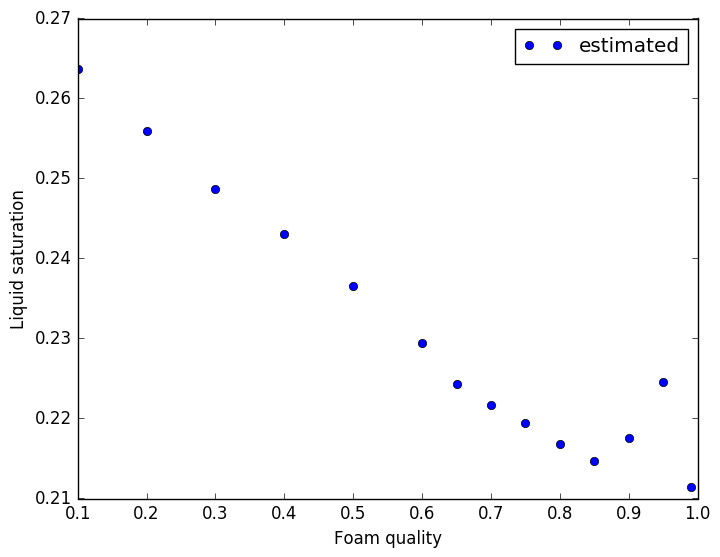

In [7]:
sw_exp = (1-swc-sgr)*(muw.*(1-fg_exp)./(krw0*muf_exp)).^(1/nw)+swc
labdaw = krw(sw_exp)./muw
labdag = kr(sw_exp)./mug
plot(fg_exp, sw_exp, "o")
xlabel("Foam quality")
ylabel("Liquid saturation")
legend(["estimated"]);

## 1.6 Visualize RelPerms

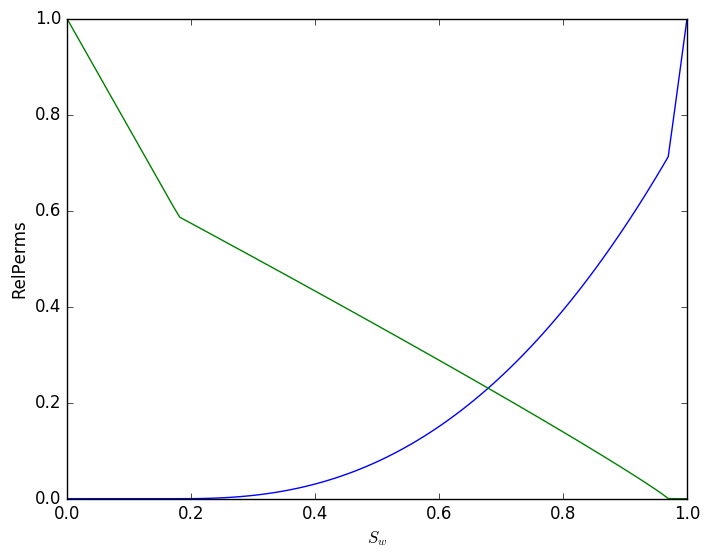

PyObject <matplotlib.text.Text object at 0x0000000023E5DAC8>

In [9]:
sw_plot = collect(linspace(0.0,1.0, 100))
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
xlabel(L"S_w")
ylabel("RelPerms")

## 1.7 Define the foam model

In [10]:
# foam model terms
fm(sw, F2)=1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi)
krg(sw, F2)=(kr(sw)./fm(sw, F2))

# Define the main functions
fg1(sw)=((kr(sw)/mug[1])./(krw(sw)/muw[1]+kr(sw)/mug[1]))
fg(sw, F2)=((krg(sw,F2)/mug[1])./(krw(sw)/muw[1]+krg(sw,F2)/mug[1]))
mu_foam(sw, F2)=(1./(krw(sw)/muw[1]+krg(sw, F2)/mug[1]))
fm2(sw, F2, F5, mu_f, u)=(1+F2[1]*(0.5+atan(F2[2].*(sw-F2[3]))/pi).*
(F5[1]./(mu_f*u/sigma_wg)).^F5[2])
krg2(sw, F2, F5, mu_f, u)=(kr(sw)./fm2(sw, F2, F5, mu_f, u))
fg2(sw, F2, F5, mu_f, u)=((krg2(sw,F2, F5, mu_f, u)/mug[1])./(krw(sw)/muw[1]+
krg2(sw,F2, F5, mu_f, u)/mug[1]));
mu_foam2(sw, F2, F5, mu_f, u)=(1./(krw(sw)/muw[1]+krg2(sw, F2, F5, mu_f, u)/mug[1]))

mu_foam2 (generic function with 1 method)

# 2. Boeije-Rossen method

I'm trying to automate the Boeije-Rossen method, using linear regression for the high quality and power-law for the low quality region.

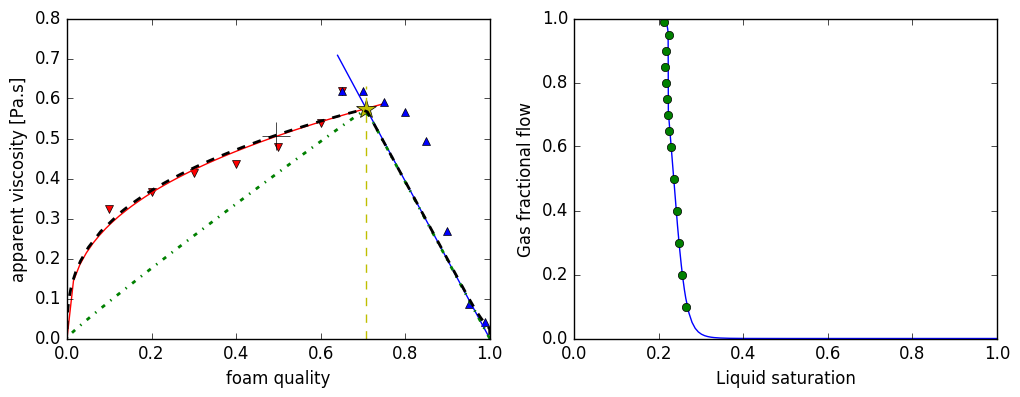

5-element Array{Float64,1}:
      2.33937e6
 100000.0      
      0.222485 
      2.0574e-5
      1.77208  

In [11]:
# fit a line to the high quality data; note: y=a+b*x
w1=ones(length(fg_high)+1) # weight factor
a_high=linreg([fg_high;1.0], [muf_high;0.0], w1)
a_high[1]=-a_high[2] # force it to go through point [1,0]
# fit a power law to the low quality data
# y=a*x^b; log(y)=log(a)+b*log(x)
w2=ones(length(fg_low)) # weight factor
w2[end-3:end]=5.0 # a larger weight to the points near the transition
a_low=linreg(log(fg_low),log(muf_low), w2)
fg_low_range=linspace(0.0, maximum(fg_low)+0.1, 50)
fg_high_range=linspace(maximum(fg_low)-0.01,1.0, 10)
figure(figsize=[12,4])
subplot(1,2,1)
plot(fg_low, muf_low, "vr", fg_low_range, exp(a_low[1])*fg_low_range.^a_low[2], "r-")
plot(fg_high, muf_high, "b^", fg_high_range, a_high[1]+a_high[2]*fg_high_range, "b-")
# find the transition quality
fun1(x)=exp(a_low[1])*x^a_low[2]-(a_high[1]+a_high[2]*x)
fg_trans = fzero(fun1, maximum(fg_low))
muf_trans = a_high[1]+a_high[2]*fg_trans
plot(fg_trans, muf_trans, "*y", markersize=15, [fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)
xlabel("foam quality")
ylabel("apparent viscosity [Pa.s]")
# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(muw[ind_mu_max].*(1-fg_trans)./(krw0*muf_trans)).^(1/nw)+swc
fmdry_br= sw_trans
# find fmmob
FM_trans = mug[ind_mu_max]/muw[ind_mu_max]*fg_trans/(1-fg_trans)*(krw(sw_trans)/kr(sw_trans))
fmmob_br= 1.0/FM_trans-1.0
# find epdry
epdry_br= 100000.0 # very convenient
# visualize the three-parameter fit
x_br=[fmmob_br, epdry_br, fmdry_br]
sw_val = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
fg_opt = fg(sw_val, x_br)
muf_opt = mu_foam(sw_val, x_br)
plot(fg_opt, muf_opt, "-.g", linewidth=2)
# calculate the epcap
dryout(x, sw)=0.5+atan(x[1]*(sw-x[2]))/π
fg_plus=0.7*fg_trans
muf_plus= exp(a_low[1])*fg_plus^a_low[2]
plot(fg_plus, muf_plus, "k+", markersize=20)
sw_plus=(1-swc-sgr)*(muw[ind_mu_max].*(1-fg_plus)./(krw0*muf_plus)).^(1/nw)+swc
#FM_plus = mug[ind_mu_max]/muw[ind_mu_max]*fg_plus/(1-fg_plus)*(krw(sw_plus)/kr(sw_plus))
#epcap_br=log((1.0/FM_trans-1.0)/(1.0/FM_plus-1.0)*
#dryout([epdry_br,fmdry_br],sw_plus)/dryout([epdry_br,fmdry_br],sw_trans))/log(muf_plus/muf_trans)
epcap_br=log((kr(sw_trans)*muf_plus-fg_plus*mug[ind_mu_max])/
(fmmob_br*mug[ind_mu_max]*fg_plus))/log(muf_trans/muf_plus)
# calculate fmcap
ind_muf_min = indmin(muf_exp)
fmcap_br= muf_exp[ind_muf_min]*u[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans/muf_exp[ind_muf_min])^epcap_br
# visualize the final results
x_br2= [fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]
sw_p = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n1 = length(sw_p)
muf_opt = zeros(n1)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n1
    fmu(x)= x-mu_foam2(sw_p[i], x_br2[1:3], x_br2[4:5], x, u_ave)
    muf_opt[i]=fzero(fmu, 0.9)
end
plot(fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), mu_foam2(sw_p, x_br2[1:3], 
x_br2[4:5], muf_opt, u_ave), "k--", linewidth=2)
subplot(1,2,2)
plot(sw_p, fg2(sw_p, x_br2[1:3], x_br2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
fit_br=[fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br]

## 4.2 Calculate the experimental foam parameters

See our paper for more details.

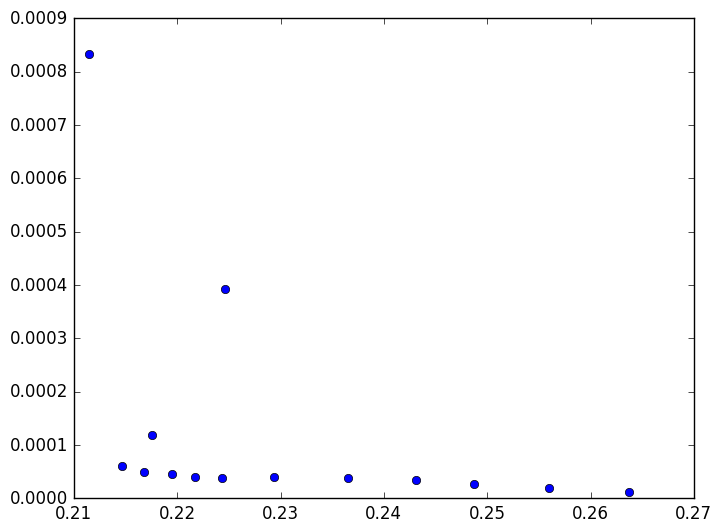

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003739CF98>

In [12]:
FM1 = mug./muw.*fg_exp./(1-fg_exp).*(krw(sw_exp)./kr(sw_exp))
FM = mug.*fg_exp./(kr(sw_exp).*muf_exp)
f_foam = 1.0./FM-1.0;
plot(sw_exp, FM, "o")

## 4.3 Create and solve a JuMP model: three parameters

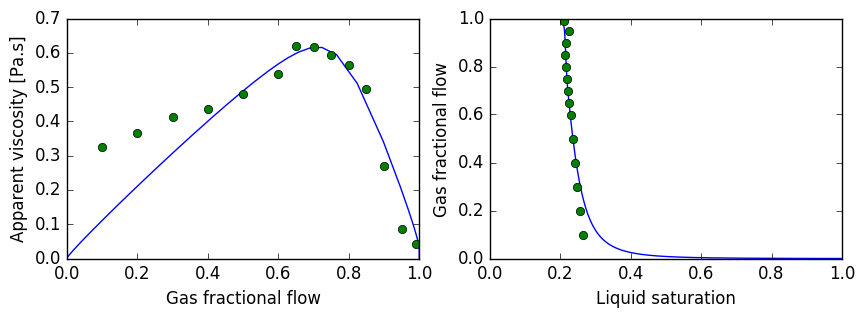

3-element Array{Float64,1}:
 27886.3     
   399.162   
     0.215391

In [14]:
m1 = Model(solver=IpoptSolver(print_level=1))
#m1 = Model(solver=NLoptSolver(algorithm=:LD_TNEWTON_RESTART))
#m = Model()
# define the variables of the foam model
@variable(m1, 10<=fmmob<=5000000)
@variable(m1, 10<=epdry<=5000, start=10000)
@variable(m1, swc<=fmdry<=swc+0.4)
w=ones(length(muf_exp))
ind_mu_max= indmax(muf_exp)
w[ind_mu_max-3:ind_mu_max+1]=100
#@setNLObjective(m1, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)))^2, i=1:n_data})
#@setNLObjective(m, Min, sum{w[i]*(tan(f_foam[i]/fmmob-0.5)-(epdry*(sw_exp[i]-fmdry))/pi)^2, i=1:n_data})
@setNLObjective(m1, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi))))^2, i=1:n_data})
solve(m1)
# get the result
x1 = [getValue(fmmob), getValue(epdry), getValue(fmdry)]
sw_val = collect(linspace(0,1.0, 500))
fg_opt = fg(sw_val, x1)
muf_opt = mu_foam(sw_val, x1)
figure(figsize=[10,3])
subplot(1,2,1)
plot(fg_opt, muf_opt, fg_exp, muf_exp, "o")
xlabel("Gas fractional flow")
ylabel("Apparent viscosity [Pa.s]")
subplot(1,2,2)
plot(sw_val, fg_opt, sw_exp, fg_exp, "o")
xlabel("Liquid saturation")
ylabel("Gas fractional flow")
x1

## 4.4 Create and solve a JuMP model: five parameters

Here's a list of NLopt algorithms (note: "NLOPT_{G,L}{N,D}_xxxx, where G/L denotes global/local optimization and N/D denotes derivative-free/gradient-based algorithms, respectively"  
  - GN_DIRECT_L
  - GN_DIRECT
  - GN_DIRECT_L_RAND
  - GN_DIRECT_NOSCAL
  - GN_DIRECT_L_NOSCAL
  - GN_DIRECT_L_RAND_NOSCAL
  - GN_ORIG_DIRECT_L
  - GN_CRS2_LM
  - G_MLSL_LDS
  - GN_MLSL
  - GD_STOGO
  - GD_STOGO_RAND
  - GN_ISRES
  - GN_ESCH
  - LN_COBYLA
  - LN_BOBYQA
  - LN_NEWUOA_BOUND
  - LN_NEWUOA
  - LN_PRAXIS
  - LN_NELDERMEAD
  - LN_SBPLX
  - LD_MMA
  - LD_CCSAQ
  - LD_SLSQP
  - LD_LBFGS
  - LD_TNEWTON_PRECOND
  - LD_TNEWTON_PRECOND_RESTART
  - LD_TNEWTON
  - LD_TNEWTON_RESTART
  - LD_VAR2
  - LD_VAR1

In [15]:
#m2 = Model(solver=IpoptSolver(print_level=1))
m2 = Model(solver=NLoptSolver(algorithm=:GN_DIRECT_L))
# define the variables of the foam model
@variable(m2, 10<=fmmob<=5000000)
@variable(m2, 10<=epdry<=100000)
@variable(m2, swc<=fmdry<=sw_exp[ind_mu_max])
@variable(m2, 1e-7<=fmcap<=1e-4)
@variable(m2, 0.0<=epcap<=4.0)
w=ones(length(muf_exp))
w[[ind_mu_max-3:ind_mu_max]]=5000
#@setNLObjective(m2, Min, sum{w[i]*(f_foam[i]-fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(FM[i]-1.0/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)
#    *(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap))^2, i=1:n_data})
#@setNLObjective(m2, Min, sum{w[i]*(muf_exp[i]-1.0/(labdaw[i]+
 #   labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))^2, i=1:n_data})
@setNLObjective(m2, Min, sum{w[i]*(1.0-(1.0/(labdaw[i]+
    labdag[i]/(1.0+fmmob*(0.5+atan(epdry*(sw_exp[i]-fmdry))/pi)*(fmcap/(u[i]*muf_exp[i]/sigma_wg))^epcap)))/muf_exp[i])^2, i=1:n_data})

# solve it
solve(m2)
# get the results
x2 = [getValue(fmmob), getValue(epdry), getValue(fmdry), 
    getValue(fmcap), getValue(epcap)]

5-element Array{Float64,1}:
     8.02605e5
 99997.5      
     0.219497 
     4.635e-5 
     1.97541  

In [14]:
fit_br

5-element Array{Float64,1}:
      2.1867e6  
 100000.0       
      0.199323  
      3.85235e-5
      1.26042   

## 4.5 Visualize the results

One method is to calculate the pressure drop in different gas and liquid rates, and plot the pressure drop contours versus gas and liquid velocity. The following result is visualized for a few average total flow rates.

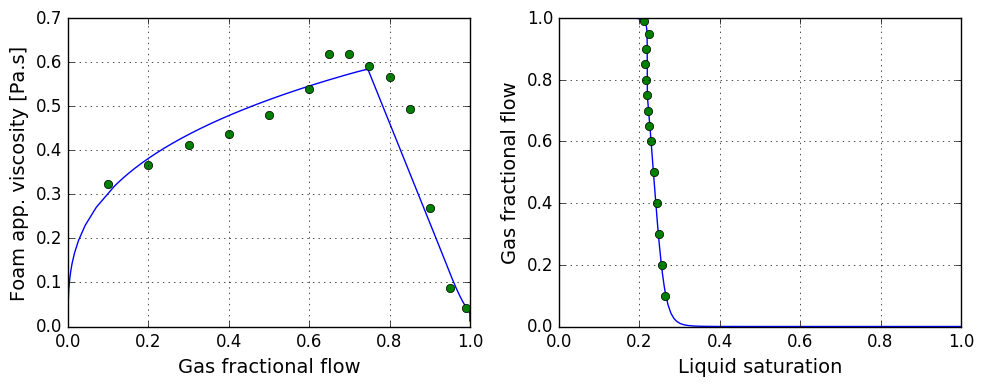

In [16]:
sw_plot = [linspace(0.0, minimum(sw_exp), 100); linspace(minimum(sw_exp)+eps(), maximum(sw_exp), 100); 
    linspace(maximum(sw_exp)+eps(), 1.0, 100)]
n_plot = length(sw_plot)
muf_opt = zeros(n_plot)
u_min = minimum(u)
u_max = maximum(u)
u_ave = mean(u)
for i=1:n_plot
    #println(sw_plot[i])
    fmu(x)= mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)-x
    fmu2(x)= x-mu_foam2(sw_plot[i], x2[1:3], x2[4:5], x, u_ave)
    mu_upper=so.fminbound(fmu, 0.0, 3.0)
    mu_lower=so.fminbound(fmu2, 0.0, 3.0)
    muf_opt[i]=fzero(fmu, [mu_lower,mu_upper])
end
figure(figsize=[10,4])
subplot(1,2,1)
plot(fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), mu_foam2(sw_plot, x2[1:3], 
x2[4:5], muf_opt, u_ave))
plot(fg_exp, muf_exp, "o")
xlabel("Gas fractional flow", fontsize=14)
ylabel("Foam app. viscosity [Pa.s]", fontsize=14)
grid()
subplot(1,2,2)
plot(sw_plot, fg2(sw_plot, x2[1:3], x2[4:5], muf_opt, u_ave), sw_exp, fg_exp, "o")
xlabel("Liquid saturation", fontsize=14)
ylabel("Gas fractional flow", fontsize=14);
grid()
tight_layout()